In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

## Definición de la carga de datos

In [2]:
def cargar_datos_txt(fichero):
    path = os.path.join(os.getcwd(), fichero)
    lineas = csv.reader(open(path, newline='\n'))
    data = []
        
        
    for linea in lineas:
        fila = []
        for i in range(0, len(linea)):
            fila.append(int(linea[i]))
        data.append(fila)
        
    return data

In [3]:
def encuentra_posicion(valor, data):
    for i in range(0, len(data)):
        for j in range(0, len(data[i])): 
            
            if valor == data[i][j]:
                x, y = i,j
                break
    return x, y
            

In [4]:
def crear_matriz_recompensas(data, fin):
    
    cantidad = len(data)*len(data[0])
    
    lista = []
    for i in range(0, cantidad):
        lista.append([-1]*cantidad)
    
    #Definir vecinos
    for i in range(0, len(data)):
        
        for j in range(0, len(data[i])):
            actual = data[i][j]
            
        
            
            if len(data)  > i+1:
                vecino1 = data[i+1][j]
                if vecino1 == fin:
                    lista[actual][vecino1] = 100
                else:
                    lista[actual][vecino1] = 0
                    
            if 0 <= i-1:
                vecino2 = data[i-1][j]
                if vecino2 == fin:
                    lista[actual][vecino2] = 100
                else:
                    lista[actual][vecino2] = 0
                    
            if len(data[i]) > j+1:
                vecino3 = data[i][j+1]
                if vecino3 == fin:
                    lista[actual][vecino3] = 100
                else:
                    lista[actual][vecino3] = 0
                
            if 0 <= j-1:
                vecino4 = data[i][j-1]
                if vecino4 == fin:
                    lista[actual][vecino4] = 100
                else:
                    lista[actual][vecino4] = 0
            
    lista[fin][fin] = 100
    return lista
            
            
    

In [5]:
#Inicializa la matriz Q para el algorimo de Q-Learning, con los pesos de cada
#acción inicializados a 0
def inicializa_Q(recompensas):
   
    lista = []
    for i in range(0, len(recompensas)):
        lista.append([0]*len(recompensas))
        
     
    return lista
    

In [6]:
def carga_matriz_recompensas(fichero):
    datos = cargar_datos_txt(fichero)
    return datos

In [25]:
def cargar_datos():
    
    tipo = int(input('''Si quieres que se genere la matriz de recompensas a partir de un tablero pulsa 0,
si quieres cargar tu matriz de recompensas pulsa 1: '''))
    
    inicio = int(input('Introduce el valor de la casilla de inicio: '))
    
    fin = int(input('Introduce el valor de la casilla objetivo: '))
    
    epochs = int(input('Introduce el número de episodios de entrenamiento: '))
    
    gamma = float(input('Introduce el valor del factor de aprendizaje gamma: '))
    
    if tipo == 0:
        
        data = cargar_datos_txt('./parametros.txt')
    
        recompensas = crear_matriz_recompensas(data, fin)
    
        q = inicializa_Q(recompensas)
        
    else:
        
        data = cargar_datos_txt('./parametros.txt')
        
        recompensas = cargar_datos_txt('./recompensas.txt')
        
        q = inicializa_Q(recompensas)
        
    
    return data, recompensas, q, inicio, fin, epochs, gamma

## Definición de algoritmo de Q-Learning Fase 1

In [8]:
def seleccionar_accion_aleatoria(valor, recompensas):
    aleatorio = -1
    while aleatorio == -1:
        casilla = np.random.randint(len(recompensas),size=1)[0]
        aleatorio = recompensas[valor][casilla]
    if casilla == -1:
        print('Casilla = ', casilla)
        print(recompensas[valor])
    return casilla    

In [9]:
def calcula_rendimiento(q):
    suma = 0
    maximo=1
    for i in range(0, len(q)):
        suma+=sum(q[i])
        if maximo < max(q[i]):
            maximo = max(q[i])
    return (suma/maximo)*100
    

In [10]:
def muestra_rendimiento(rendimiento):
    plt.title('Rendimiento del algoritmo de Q-Learning')
    plt.xlabel('Número de episodios de entrenamiento')
    plt.ylabel('Valor del rendimiento del algoritmo')
    plt.plot(rendimiento)
    plt.show()

In [69]:
def calcular_camino(q,inicio,fin):
    posicion = inicio
    camino = []
    camino.append(inicio)
    converge = True
    representacion = ''
    
    while posicion != fin:
        
        maximo = max(q[posicion])
        siguiente = q[posicion].index(maximo)
        posicion = siguiente
    
        if(posicion in camino):
            print('El algoritmo no ha logrado encontrar un camino óptimo')
            converge = False
            break

        camino.append(siguiente)
        
    for i in range(len(camino)):
        representacion += str(camino[i])+' -> '
        
    if(converge):    
        print('El camino óptimo es: ', representacion[0:-4])

In [46]:
def q_learning(data, recompensas, q, inicio, fin, epochs, gamma):
    rendimiento = []
    for epoch in range(0, epochs):
        
        #print('Época = '+str(epoch), 'Completado al '+str((epoch/epochs)*100)+'%')
        i = np.random.randint(len(data) ,size=1)[0]
        j = np.random.randint(len(data[i]),size=1)[0]
        estado = data[i][j]
        primero = True
        
        while (estado != fin) or (primero):
            
            accion = seleccionar_accion_aleatoria(estado, recompensas)
            maximo = max(q[accion])
            q[estado][accion] = recompensas[estado][accion] + gamma*maximo
            estado = accion
            primero = False
            
        rendimiento.append(calcula_rendimiento(q))
    
    return q, rendimiento
    

## Definición de algoritmo de Q-Learning Fase 2

In [14]:
def selecionar_accion_aleatoria_F2(estado, recompensas, q, epsilon):
    aleatorio = np.random.rand(1)[0]
    
    if aleatorio < epsilon:
        res = seleccionar_accion_aleatoria(estado, recompensas)
    else:
        maximo = max(q[estado])
        res = q[estado].index(maximo)
    return res

In [49]:
def q_learning_F2(data, recompensas, q, inicio, fin, epochs, gamma, epsilon, alpha):
    rendimiento = []
    for epoch in range(0, epochs):
        
        #print('Época = '+str(epoch), 'Completado al '+str((epoch/epochs)*100)+'%')
        i = np.random.randint(len(data) ,size=1)[0]
        j = np.random.randint(len(data[i]),size=1)[0]
        estado = data[i][j]
        primero = True
        
        while (estado != fin) or (primero):
            
            accion = selecionar_accion_aleatoria_F2(estado, recompensas, q, epsilon)
            maximo = max(q[accion])
            q[estado][accion] = recompensas[estado][accion] + gamma*maximo
            estado = accion
            primero = False
            
        rendimiento.append(calcula_rendimiento(q))
        epsilon *= alpha
        
    
    return q, rendimiento

## Recopilación de todo en una función

In [40]:
def ejecuta_QLearning():
    
    data, recompensas, q, inicio, fin, epochs, gamma = cargar_datos()
    
    eleccion = int(input('¿Qué algoritmo quieres usar, el 1 o el 2?: '))
    
    if eleccion == 1:
        q, rendimiento  = q_learning(data, recompensas, q, inicio, fin, epochs, gamma)
    else:
        
        epsilon = float(input('Introduce el valor del parámetro epsilon: '))
        alpha = float(input('Introduce el valor del parámetro alpha: '))
        
        q, rendimiento  = q_learning_F2(data, recompensas, q, inicio, fin, epochs, gamma, epsilon, alpha)
        
    print('\nMatriz Q obtenida =\n')
    for i in range(len(q)):
        print(str(i)+':',q[i])
        
    muestra_rendimiento(rendimiento)
        
    return q, rendimiento, inicio, fin

# Main:

Si quieres que se genere la matriz de recompensas a partir de un tablero pulsa 0,
si quieres cargar tu matriz de recompensas pulsa 1: 1
Introduce el valor de la casilla de inicio: 0
Introduce el valor de la casilla objetivo: 13
Introduce el número de episodios de entrenamiento: 40
Introduce el valor del factor de aprendizaje gamma: 0.9
¿Qué algoritmo quieres usar, el 1 o el 2?: 2
Introduce el valor del parámetro epsilon: 0.8
Introduce el valor del parámetro alpha: 0.8

Matriz Q obtenida =

0: [0, 140.32185879429005, 0, 40.59116186581001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1: [65.61000000000001, 0, 23.380082100000003, 0, 155.91317643810004, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: [25.977869000000002, 140.32185879429005, 0, 27.766866501000003, 0, 0, 0, 23.380082100000003, 0, 0, 0, 0, 0, 0, 0]
3: [103.76155890000001, 0, 23.380082100000003, 0, 0, 0, 0, 0, 21.852073890000003, 0, 0, 0, 0, 0, 0]
4: [0, 0.0, 0, 0, 0, 72.9, 0, 0, 0, 173.23686270900004, 0, 0, 0, 0, 0]
5: [0, 0, 0, 0, 81.0, 0, 52.33410000

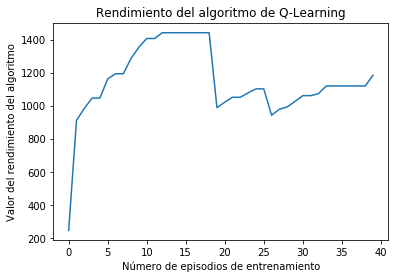

El camino óptimo es:  0 -> 1 -> 4 -> 9 -> 13


In [88]:
def main(): 
    
    q, rendimiento, inicio, fin = ejecuta_QLearning()
    
    calcular_camino(q,inicio,fin)    
    
if __name__ == "__main__": main()

In [ ]:
'''
i = 0.1
while i<=1:
    for b in range(0,4):
        q = inicializa_Q(data)
        q, rendimiento = q_learning_F2(data, recompensas, q, 0, 6, 50, 0.5, 1, i)
        print('i = ', i)
        muestra_rendimiento(rendimiento)
    i+=0.1
'''